# Machine learning compilation of quantum circuits -- experiments
> Flexible and efficient learning with JAX+numpy
- toc: true 
- badges: true
- comments: true
- categories: [qiskit, JAX, machine learning]
- image: images/upsidedown.jpg

# Introduction

Introduction ... 

# Imports

In [57]:
import jax.numpy as jnp
import numpy as np

from jax import random, value_and_grad, ops, jit, lax, vmap, grad, partial
key = random.PRNGKey(42)

# !pip install tensornetwork
# !pip install optax
# !pip install qiskit
# !pip install pylatexenc

import tensornetwork as tn
tn.set_default_backend('jax')

import optax

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator, Statevector
from qiskit.circuit import Parameter
from qiskit.transpiler.passes.synthesis import UnitarySynthesis
from qiskit.transpiler import PassManager
from qiskit.converters import circuit_to_gate

from scipy.stats import unitary_group

import matplotlib.pyplot as plt
import re

# Building blocks

The circuits that we are going to be train will be built out of two types of two-qubit blocks. Here are the definitions:

In [69]:
cx_mat = jnp.array([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 0, 1],
                    [0, 0, 1, 0]])

cz_mat = jnp.array([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, -1]])

x_mat = jnp.array([[0, 1],
                   [1, 0]])

y_mat = jnp.array([[0, -1j],
                   [1j, 0]], dtype=jnp.complex64)

z_mat = jnp.array([[1, 0],
                   [0, -1]])

def rx_mat(a):
    return jnp.cos(a/2)*jnp.identity(2)-1j*x_mat*jnp.sin(a/2)

def ry_mat(a):
    return jnp.cos(a/2)*jnp.identity(2)-1j*y_mat*jnp.sin(a/2)

def rz_mat(a):
    return jnp.cos(a/2)*jnp.identity(2)-1j*z_mat*jnp.sin(a/2)

class block():
    def __init__(self, gate_name, angles):
        self.gate_name = gate_name
        self.angles = angles
        
    def circuit(self):
        qc = QuantumCircuit(2)
        if self.gate_name == 'cx':
            qc.cx(0, 1)
        elif self.gate_name == 'cz':
            qc.cz(0, 1)
        else:
            print("Gate '{}' not yet supported'".format(self.gate_name))
        
        angles = np.array(self.angles) # convert from JAX array to numpy array if applicable.
        
        qc.ry(angles[0], 0)
        qc.rx(angles[1], 0)
        qc.ry(angles[2], 1)
        qc.rx(angles[3], 1)
        
        return qc
    
    def unitary(self):
        if self.gate_name == 'cx':
            entangling_matrix = cx_mat
        elif self.gate_name == 'cz':
            entangling_matrix = cz_mat
        else:
            print("Gate '{}' not yet supported'".format(self.gate_name))
        
        x_rotations = jnp.kron(rx_mat(self.angles[1]), rx_mat(self.angles[3]))
        y_rotations = jnp.kron(ry_mat(self.angles[0]), ry_mat(self.angles[2]))
        
        return x_rotations @ y_rotations @ entangling_matrix

Here is how they look:
`cz` block

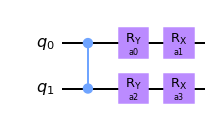

In [71]:
a0, a1, a2, a3 = [Parameter(a) for a in ['a0', 'a1', 'a2', 'a3']]
block('cz', [a0, a1, a2, a3]).circuit().draw(output='mpl')

and `cx` block

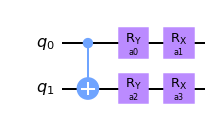

In [72]:
block('cx', [a0, a1, a2, a3]).circuit().draw(output='mpl')

They only differ by the type of the two-qubit gate. The circuits that we are going to build seem to do equally well for any type of two-qubit gate. I will mostly use `cz` gate because it is symmetric under the swap of qubits, but I will also occasinally bring up the `cx` gate to illustrate that it has the same performance. Angles $a_0$-$a_3$ are going to be optimized. Together with the circuits our `block` class can return a unitary corresponding to the cicuit. Of course we could have extracted the unitary from the circuit itself via `qiskit` API, but this would make the matrix representation incompatible with JAX that we will rely heavily for optimization. So at this point we need a bit of wheel reivention. Let us check that our implementation is consisten with `qiskit`:

In [73]:
key, subkey = random.split(key)
angles = random.uniform(key, shape=(4,), minval=0, maxval=2*jnp.pi)
for gate in ['cx', 'cz']:
    b = block(gate, angles)
    qc = b.circuit()
    qs_unitary = Operator(qc.reverse_bits()).data # Yes, we need to reverse bits in qiskit to match our conventions.
    our_unitary = b.unitary()
    print(jnp.allclose(qs_unitary, our_unitary))

True
True


# Ansatz circuits

Now, let us build our ansatz circuits from these blocks.

## The code

In [469]:
class ansatz():
    
    @staticmethod 
    def sequ_placements(num_qubits, depth):
        all_pairs = [[i,j] for i in range(num_qubits) for j in range(i+1, num_qubits)]
        complete_placements = all_pairs * (depth//len(all_pairs))
        incomplete_placements = all_pairs[:depth%len(all_pairs)]
        return complete_placements+incomplete_placements
    
    def __init__(self, num_qubits, block_type, angles=None, placements=None, pattern=None):
        
        self.num_qubits = num_qubits
        self.block_type = block_type
        
        assert placements or pattern is not None, 'Either pattern of placements must be provided'
        if placements is not None:
            self.placements = placements
        else:
            pattern_name, depth = pattern
            assert pattern_name == 'sequ', 'Patters other then sequ are not supported'
            self.placements = ansatz.sequ_placements(num_qubits, depth)
        
        # If  angles are not provided use a an appropriate integer range.
        if angles is None:
            angles = list(range(3*num_qubits+4*len(self.placements)))
        
        self.all_angles = angles
        self.surface_angles = jnp.array(angles[:3*num_qubits]).reshape(num_qubits, 3)
                
        if len(angles)>3*num_qubits:
            self.block_angles = jnp.array(angles[3*num_qubits:]).reshape(len(self.placements), 4)
        else:
            self.block_angles = []
        
        self.pattern = pattern
        
    def circuit(self):
        qc = QuantumCircuit(self.num_qubits)
        
        # Initial rounf of single-qubit gates
        for n, a in enumerate(self.surface_angles):
            qc.rz(a[0], n)
            qc.rx(a[1], n)
            qc.rz(a[2], n)
        
        # Enatgling gates accoring to placements
        for a, p in zip(self.block_angles, self.placements):
            qc_block = block(self.block_type, a).circuit() 
            qc = qc.compose(qc_block, p)
            
        return qc
    
    @staticmethod
    def transposition(n, placement):
        w = len(placement)
        t = list(range(w, n))
    
        for i, p in enumerate(placement):
            t.insert(p, i)
    
        return t
    
    @staticmethod
    def apply_gate_to_tensor(gate, tensor, placement):
        gate_width = int(len(gate.shape)/2)
        tensor_width = int(len(tensor.shape)/2)
        gate_contraction_axes = list(range(gate_width, 2*gate_width))
        
        contraction = jnp.tensordot(gate, tensor, axes=[gate_contraction_axes, placement])
        t = transposition(tensor_width, placement) + list(range(tensor_width, 2*tensor_width)) # last indices are intact

        return jnp.transpose(contraction, axes=t)
        
    
    def unitary(self):
        """Construct unitary using ordinary for loops."""
        u = jnp.identity(2**self.num_qubits).reshape([2]*self.num_qubits*2)
        
        for i, a in enumerate(self.surface_angles):
            gate = rz_mat(a[2]) @ rx_mat(a[1]) @ rz_mat(a[0])
            u = ansatz.apply_gate_to_tensor(gate, u, [i])
        
        for a, p in zip(self.block_angles, self.placements):
            gate = block(self.block_type, a).unitary().reshape(2,2,2,2)
            u = ansatz.apply_gate_to_tensor(gate, u, p)
        
        return u.reshape(2**self.num_qubits, 2**self.num_qubits)
    
    def unitary_i(self):
        """Construct unitary using lax.fori_loop. Faster, but less flexible."""
        pattern_name, depth = self.pattern
        assert pattern_name == 'sequ', 'iunitary is only supported for sequ pattern'
        
        u = jnp.identity(2**self.num_qubits).reshape([2]*self.num_qubits*2)
        
        # Initial round of single-qubits gates.
        # I do not expect significant speed up from laxing this loop, so I leave it as is.
        for i, a in enumerate(self.surface_angles):
            gate = rz_mat(a[2]) @ rx_mat(a[1]) @ rz_mat(a[0])
            u = ansatz.apply_gate_to_tensor(gate, u, [i])
        
        # Loop over complete sequ layers.
        layer_depth = int(self.num_qubits*(self.num_qubits-1)/2) # Number of 2-qubit gates in a complete `sequ` layer.
        num_complete_layers = len(self.block_angles) // layer_depth
        complete_layers_angles = self.block_angles[:layer_depth*num_complete_layers].reshape(num_complete_layers, layer_depth, 4)
        
        def apply_layer(i, u, layers_angles):
            angles = layers_angles[i]
            placements = ansatz.sequ_placements(self.num_qubits, layer_depth)
            
            for a, p in zip(angles, placements):
                gate = block(self.block_type, a).unitary().reshape(2,2,2,2)
                u = ansatz.apply_gate_to_tensor(gate, u, p)
            
            return u
        
        if num_complete_layers>0:
            u = lax.fori_loop(0, num_complete_layers, lambda i, u: apply_layer(i, u, complete_layers_angles), u)
        
        # Finally, add remaining gates in the last (incomplete) layer.
        remainder_block_angles = self.block_angles[layer_depth*num_complete_layers:]
        remainder_placements = self.placements[layer_depth*num_complete_layers:]
        for a, p in zip(remainder_block_angles, remainder_placements):
            gate = block(self.block_type, a).unitary().reshape(2,2,2,2)
            u = ansatz.apply_gate_to_tensor(gate, u, p)
            
        return u.reshape(2**self.num_qubits, 2**self.num_qubits)

## Performance

In [ ]:
@partial(jit, static_argnums=(1,2,))
@grad
def u_plain(angles, n_q, depth):
    u = ansatz(n_q, 'cz', pattern=['sequ', depth], angles=angles).unitary()
    return jnp.abs(u).sum()

@partial(jit, static_argnums=(1,2,))
@grad
def u_i(angles, n_q, depth):
    u = ansatz(n_q, 'cz', pattern=['sequ', depth], angles=angles).unitary_i()
    return jnp.abs(u).sum()


n_q = 5
depth = 50
angles = jnp.array(range(3*n_q+depth*4), dtype='float32')

%%time
test_plain = u_plain(angles, n_q, depth)

%%time
test_i = u_i(angles, n_q, depth)

jnp.allclose(test_plain, test_i, atol=1e-07, rtol=1e-04)